# HO SOLO UN TX E UN RX

*TX1-->RX1 canale 6 |
 TX2-->RX2 canale 11*

In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from hampel import hampel
from scipy.signal import savgol_filter

In [2]:
assenza = pd.read_csv('Vecchi_dati/assenza2conorario.csv')

una_movimento=pd.read_csv('Vecchi_dati/unapersonachesimuoveconorario.csv')

una_ferma=pd.read_csv('Vecchi_dati/unapersonafermaconorario.csv')

due_movimento=pd.read_csv('Vecchi_dati/duepersonechesimuovonoconorario.csv')

due_ferme=pd.read_csv('Vecchi_dati/duepersonefermeconorario.csv')

una_entra_esce=pd.read_csv('Vecchi_dati/unapersonaentraesceconorario.csv')

In [3]:
def convert_to_complex(csi_data):
    # Assumiamo che csi_data sia una lista con alternanza di I e Q
    complex_data = []
    for i in range(0, len(csi_data), 2):  # passo di 2 per prendere I e Q
        real = csi_data[i]
        imag = csi_data[i+1] if i+1 < len(csi_data) else 0
        complex_data.append(complex(real, imag))
    return complex_data

In [4]:
# convertiamo le stringhe in liste di numeri 

assenza['data'] = assenza['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

una_movimento['data'] = una_movimento['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
una_ferma['data'] = una_ferma['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
due_movimento['data'] = due_movimento['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
due_ferme['data'] = due_ferme['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

una_entra_esce['data'] = una_entra_esce['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)



In [5]:
#trasformo i dati in numeri complessi
assenza['data_complex'] = assenza['data'].apply(convert_to_complex)
una_movimento['data_complex'] = una_movimento['data'].apply(convert_to_complex)

una_ferma['data_complex'] = una_ferma['data'].apply(convert_to_complex)
due_movimento['data_complex'] = due_movimento['data'].apply(convert_to_complex)

due_ferme['data_complex'] = due_ferme['data'].apply(convert_to_complex)
una_entra_esce['data_complex'] = una_entra_esce['data'].apply(convert_to_complex)



In [6]:
# Seleziona solo le colonne di interesse, in questo caso tieniamo i csi e i timestamp 
columns_to_keep = ['data_complex', 'local_timestamp']

# Rimuovi tutte le altre colonne
assenza = assenza[columns_to_keep]
una_movimento = una_movimento[columns_to_keep]

una_ferma = una_ferma[columns_to_keep]
due_movimento = due_movimento[columns_to_keep]

due_ferme = due_ferme[columns_to_keep]
una_entra_esce = una_entra_esce[columns_to_keep]



In [ ]:
# Separiamo i numeri complessi in colonne direttamente nel DataFrame originale
assenza[[f'{i}' for i in range(len(assenza['data_complex'].iloc[0]))]] = pd.DataFrame(assenza['data_complex'].tolist(), index=assenza.index)
una_movimento[[f'{i}' for i in range(len(una_movimento['data_complex'].iloc[0]))]] = pd.DataFrame(una_movimento['data_complex'].tolist(), index=una_movimento.index)

una_ferma[[f'{i}' for i in range(len(una_ferma['data_complex'].iloc[0]))]] = pd.DataFrame(una_ferma['data_complex'].tolist(), index=una_ferma.index)
due_movimento[[f'{i}' for i in range(len(due_movimento['data_complex'].iloc[0]))]] = pd.DataFrame(due_movimento['data_complex'].tolist(), index=due_movimento.index)

due_ferme[[f'{i}' for i in range(len(due_ferme['data_complex'].iloc[0]))]] = pd.DataFrame(due_ferme['data_complex'].tolist(), index=due_ferme.index)
una_entra_esce[[f'{i}' for i in range(len(una_entra_esce['data_complex'].iloc[0]))]] = pd.DataFrame(una_entra_esce['data_complex'].tolist(), index=una_entra_esce.index)


In [9]:
# Rimuoviamo la colonna originale dei numeri complessi che ora sono state separate in colonne individuali

assenza= assenza.drop(columns=['data_complex'])
una_movimento= una_movimento.drop(columns=['data_complex'])

una_ferma= una_ferma.drop(columns=['data_complex'])
due_movimento= due_movimento.drop(columns=['data_complex'])

due_ferme= due_ferme.drop(columns=['data_complex'])
una_entra_esce= una_entra_esce.drop(columns=['data_complex'])


In [10]:
def split_csi_dataset(df: pd.DataFrame):
    """
    Divide un DataFrame CSI in due dataset separati:
      - LLTF (0..63)
      - HT-LTF (-64..-1, 0..63)
    
    Restituisce:
      lltf_data_df, htltf_data_df
    """
    # --- 0) Meta colonne da tenere (solo quelle presenti davvero) ---
    candidate_meta = ["rx", "local_timestamp", "mac"]
    meta_cols = [c for c in candidate_meta if c in df.columns]

    # --- 1) Mappa colonne 'numeric-like' -> interi ---
    numlike_map = {}
    for c in df.columns:
        try:
            ci = int(c)
            numlike_map[c] = ci
        except Exception:
            pass
    if numlike_map:
        df = df.rename(columns=numlike_map)

    # --- 2) Se NON abbiamo le 192 colonne 0..191, prova da 'data_complex' ---
    needed_cols = list(range(192))
    missing_numeric = [c for c in needed_cols if c not in df.columns]

    if missing_numeric:
        if "data_complex" not in df.columns:
            raise ValueError("Non trovo né le colonne 0..191 né la colonna 'data_complex'.")
        expanded = pd.DataFrame(
            df["data_complex"].apply(
                lambda x: list(x) if isinstance(x, (list, tuple, np.ndarray)) else np.nan
            ).tolist(),
            index=df.index
        )
        expanded.columns = list(range(expanded.shape[1]))
        if expanded.shape[1] < 192:
            raise ValueError(f"'data_complex' non ha 192 elementi (ne ha {expanded.shape[1]}).")
        expanded = expanded[needed_cols]
        for c in needed_cols:
            if c not in df.columns:
                df[c] = expanded[c]

    # --- 3) Indici sorgente ---
    lltf_src   = list(range(0, 64))       # 0..63
    ht_pos_src = list(range(64, 128))     # 64..127
    ht_neg_src = list(range(128, 192))    # 128..191

    # --- 4) Costruisci i due dataset ---
    lltf_df = pd.concat([df[meta_cols], df[lltf_src]], axis=1)

    htltf_part = pd.concat([df[ht_pos_src], df[ht_neg_src]], axis=1)
    htltf_part.columns = list(range(0, 64)) + list(range(-64, 0))
    ordered = list(range(-64, 0)) + list(range(0, 64))
    htltf_df = pd.concat([df[meta_cols], htltf_part[ordered]], axis=1)

    # --- 5) Rimuovi colonne sempre 0 ---
    def clean_zero_only(data_df):
        data_cols = [c for c in data_df.columns if c not in meta_cols]
        vals = data_df[data_cols].applymap(
            lambda z: 0+0j if (z is None or (isinstance(z, float) and np.isnan(z))) else complex(z)
        )
        mask_keep = (vals.to_numpy() != 0).any(axis=0)
        cols_to_keep = [col for col, keep in zip(data_cols, mask_keep) if keep]
        return pd.concat([data_df[meta_cols], data_df[cols_to_keep]], axis=1)

    lltf_cleaned = clean_zero_only(lltf_df)
    htltf_cleaned = clean_zero_only(htltf_df)

    return lltf_cleaned, htltf_cleaned


In [11]:
lltf_assenza, htltf_assenza = split_csi_dataset(assenza)
lltf_una_ferma, htltf_una_ferma = split_csi_dataset(una_ferma)

lltf_una_movimento, htltf_una_movimento = split_csi_dataset(una_movimento)
lltf_due_movimento, htltf_due_movimento = split_csi_dataset(due_movimento)

lltf_due_ferme, htltf_due_ferme = split_csi_dataset(due_ferme)
lltf_una_entra_esce, htltf_una_entra_esce = split_csi_dataset(una_entra_esce)


C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\2053294205

In [12]:
#levo le sottoportanti pilota  -53, -25, -11, +11, +25, +53, queste sono indicate nel documento esp 
def remove_pilot_subcarriers(df):
    pilot_indices = [-53, -25, -11, 11, 25, 53]
    cols_to_remove = [col for col in pilot_indices if col in df.columns]
    df_cleaned = df.drop(columns=cols_to_remove)
    return df_cleaned

htltf_assenza = remove_pilot_subcarriers(htltf_assenza)
htltf_una_ferma = remove_pilot_subcarriers(htltf_una_ferma)

htltf_una_movimento = remove_pilot_subcarriers(htltf_una_movimento)
htltf_due_movimento = remove_pilot_subcarriers(htltf_due_movimento)

htltf_due_ferme = remove_pilot_subcarriers(htltf_due_ferme)
htltf_una_entra_esce = remove_pilot_subcarriers(htltf_una_entra_esce)


In [13]:
#recupero gli indici delle sottoportanti 
subcarriers_htltf = [col for col in htltf_assenza.columns if col not in ['local_timestamp','rx']]

subcarriers_lltf=[col for col in lltf_assenza.columns if col not in ['local_timestamp','rx']]

#calcolo quante sono 
num_subcarriers_htltf = len(subcarriers_htltf)

num_subcarriers_lltf = len(subcarriers_lltf)    

In [14]:
num_subcarriers_htltf

108

In [15]:
num_subcarriers_lltf

52

In [16]:
def drop_time_window(df, time_col='local_timestamp', seconds=60, mode='head'):
    """
    Rimuove dal DataFrame tutte le righe dei primi o ultimi `seconds` secondi,
    sulla base della colonna temporale `time_col`.
    - mode='head' rimuove i primi N secondi
    - mode='tail' rimuove gli ultimi N secondi
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if mode == 'head':
        t0 = df[time_col].min()
        mask = df[time_col] >= (t0 + pd.Timedelta(seconds=seconds))
    elif mode == 'tail':
        t_end = df[time_col].max()
        mask = df[time_col] <= (t_end - pd.Timedelta(seconds=seconds))
    else:
        raise ValueError("mode deve essere 'head' oppure 'tail'")
    return df[mask].reset_index(drop=True)

In [ ]:
htltf_assenza = remove_pilot_subcarriers(htltf_assenza)
htltf_una_ferma = remove_pilot_subcarriers(htltf_una_ferma)

htltf_una_movimento = remove_pilot_subcarriers(htltf_una_movimento)
htltf_due_movimento = remove_pilot_subcarriers(htltf_due_movimento)

htltf_due_ferme = remove_pilot_subcarriers(htltf_due_ferme)
htltf_una_entra_esce = remove_pilot_subcarriers(htltf_una_entra_esce)

In [23]:
# in questa sezione tolgo i primi e gli ultimi secondi di ogni acquisizione per eliminare i momenti in cui le persone non fanno il training
# QUESTO PER LE LLTF
lltf_assenza = drop_time_window(lltf_assenza, time_col='local_timestamp', seconds=60, mode='head')
htltf_assenza = drop_time_window(htltf_assenza, time_col='local_timestamp', seconds=60, mode='head')

htltf_una_ferma = drop_time_window(htltf_una_ferma, time_col='local_timestamp', seconds=60, mode='head') 
lltf_una_ferma = drop_time_window(lltf_una_ferma, time_col='local_timestamp', seconds=60, mode='head')

htltf_una_movimento = drop_time_window(htltf_una_movimento, time_col='local_timestamp', seconds=60, mode='head')
lltf_una_movimento = drop_time_window(lltf_una_movimento, time_col='local_timestamp', seconds=60, mode='head')

htltf_due_movimento = drop_time_window(htltf_due_movimento, time_col='local_timestamp', seconds=120, mode='head')
lltf_due_movimento = drop_time_window(lltf_due_movimento, time_col='local_timestamp', seconds=120, mode='head')

htltf_due_ferme = drop_time_window(htltf_due_ferme, time_col='local_timestamp', seconds=60, mode='head')
lltf_due_ferme = drop_time_window(lltf_due_ferme, time_col='local_timestamp', seconds=60, mode='head')


In [ ]:
# in questa sezione tolgo i primi e gli ultimi secondi di ogni acquisizione per eliminare i momenti in cui le persone non fanno il training
# QUESTO PER LE LLTF
lltf_assenza = drop_time_window(lltf_assenza, time_col='local_timestamp', seconds=60, mode='tail')
htltf_assenza = drop_time_window(htltf_assenza, time_col='local_timestamp', seconds=60, mode='tail')

htltf_una_ferma = drop_time_window(htltf_una_ferma, time_col='local_timestamp', seconds=60, mode='tail') 
lltf_una_ferma = drop_time_window(lltf_una_ferma, time_col='local_timestamp', seconds=60, mode='tail')

htltf_una_movimento = drop_time_window(htltf_una_movimento, time_col='local_timestamp', seconds=60, mode='tail')
lltf_una_movimento = drop_time_window(lltf_una_movimento, time_col='local_timestamp', seconds=60, mode='tail')

htltf_due_movimento = drop_time_window(htltf_due_movimento, time_col='local_timestamp', seconds=120, mode='tail')
lltf_due_movimento = drop_time_window(lltf_due_movimento, time_col='local_timestamp', seconds=120, mode='tail')

htltf_due_ferme = drop_time_window(htltf_due_ferme, time_col='local_timestamp', seconds=60, mode='tail')
lltf_due_ferme = drop_time_window(lltf_due_ferme, time_col='local_timestamp', seconds=60, mode='tail')


In [26]:
def apply_abs_to_subcarriers(df, subcarrier_cols):
    """
    Restituisce una copia del DataFrame con il modulo applicato solo alle colonne dei subcarrier.
    Non tocca eventuali colonne identificative (es: 'mac', timestamp, ecc).
    """
    df_mod = df.copy()
    df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
    return df_mod

In [27]:
# Calcolo il modulo dei dati LLTF per ogni condizione e per ogni ricevitore

modulo_assenza_lltf = lltf_assenza.copy()
modulo_assenza_lltf[subcarriers_lltf] = lltf_assenza[subcarriers_lltf].applymap(np.abs)

modulo_una_ferma_lltf = lltf_una_ferma.copy()
modulo_una_ferma_lltf[subcarriers_lltf] = lltf_una_ferma[subcarriers_lltf].applymap(np.abs)

modulo_due_movimento_lltf = lltf_due_movimento.copy()
modulo_due_movimento_lltf[subcarriers_lltf] = lltf_due_movimento[subcarriers_lltf].applymap(np.abs)

modulo_due_ferme_lltf = lltf_due_ferme.copy()
modulo_due_ferme_lltf[subcarriers_lltf] = lltf_due_ferme[subcarriers_lltf].applymap(np.abs)

modulo_una_movimento_lltf = lltf_una_movimento.copy()
modulo_una_movimento_lltf[subcarriers_lltf] = lltf_una_movimento[subcarriers_lltf].applymap(np.abs)

modulo_una_ferma_lltf = lltf_una_ferma.copy()
modulo_una_ferma_lltf[subcarriers_lltf] = lltf_una_ferma[subcarriers_lltf].applymap(np.abs)

modulo_una_entra_esce_lltf = lltf_una_entra_esce.copy()
modulo_una_entra_esce_lltf[subcarriers_lltf] = lltf_una_entra_esce[subcarriers_lltf].applymap(np.abs)

C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\3790818802.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_assenza_lltf[subcarriers_lltf] = lltf_assenza[subcarriers_lltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\3790818802.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_una_ferma_lltf[subcarriers_lltf] = lltf_una_ferma[subcarriers_lltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\3790818802.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_due_movimento_lltf[subcarriers_lltf] = lltf_due_movimento[subcarriers_lltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\3790818802.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_due_ferme_lltf[subcarriers_lltf] = lltf_due_ferme[subcarriers_lltf].applymap(np.abs)
C:\Users\mariu\AppData

In [28]:
# Calcolo il modulo dei dati htltf per ogni condizione e per ogni ricevitore

modulo_assenza_htltf = htltf_assenza.copy()
modulo_assenza_htltf[subcarriers_htltf] = htltf_assenza[subcarriers_htltf].applymap(np.abs)

modulo_una_ferma_htltf = htltf_una_ferma.copy()
modulo_una_ferma_htltf[subcarriers_htltf] = htltf_una_ferma[subcarriers_htltf].applymap(np.abs)

modulo_due_movimento_htltf = htltf_due_movimento.copy()
modulo_due_movimento_htltf[subcarriers_htltf] = htltf_due_movimento[subcarriers_htltf].applymap(np.abs)

modulo_due_ferme_htltf = htltf_due_ferme.copy()
modulo_due_ferme_htltf[subcarriers_htltf] = htltf_due_ferme[subcarriers_htltf].applymap(np.abs)

modulo_una_movimento_htltf = htltf_una_movimento.copy()
modulo_una_movimento_htltf[subcarriers_htltf] = htltf_una_movimento[subcarriers_htltf].applymap(np.abs)

modulo_una_ferma_htltf = htltf_una_ferma.copy()
modulo_una_ferma_htltf[subcarriers_htltf] = htltf_una_ferma[subcarriers_htltf].applymap(np.abs)

modulo_una_entra_esce_htltf = htltf_una_entra_esce.copy()
modulo_una_entra_esce_htltf[subcarriers_htltf] = htltf_una_entra_esce[subcarriers_htltf].applymap(np.abs)

C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\1867132494.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_assenza_htltf[subcarriers_htltf] = htltf_assenza[subcarriers_htltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\1867132494.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_una_ferma_htltf[subcarriers_htltf] = htltf_una_ferma[subcarriers_htltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\1867132494.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_due_movimento_htltf[subcarriers_htltf] = htltf_due_movimento[subcarriers_htltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_17896\1867132494.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_due_ferme_htltf[subcarriers_htltf] = htltf_due_ferme[subcarriers_htltf].applymap(np.abs)
C:\Use

In [29]:
def segment_csi_data(df, 
                     time_col='local_timestamp', 
                     subcarrier_cols=None, 
                     window_sec=6, 
                     overlap_sec=3):
    """
    Segmenta i dati CSI in finestre temporali sovrapposte.
    - df: DataFrame con almeno colonna temporale e sottoportanti (ampiezze float o |csi|).
    - time_col: nome colonna timestamp (stringa compatibile con pd.to_datetime)
    - subcarrier_cols: lista colonne delle sottoportanti (se None, tutte quelle numeriche)
    - window_sec: durata finestra (secondi)
    - overlap_sec: overlap tra finestre (secondi)
    Ritorna: lista di array shape (n_packets_window, n_subcarriers)
    """
    # Preprocessing robusto
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if subcarrier_cols is None:
        # Prendi solo colonne numeriche (escludendo timestamp/mac)
        subcarrier_cols = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Ordina per timestamp
    df = df.sort_values(time_col).reset_index(drop=True)
    times = df[time_col].values.astype('datetime64[s]')
    start_time = times[0]
    end_time = times[-1]
    window = np.timedelta64(window_sec, 's')
    step = np.timedelta64(window_sec - overlap_sec, 's')

    bundles = []
    w = 0
    current_start = start_time
    while current_start + window <= end_time:
        current_end = current_start + window
        mask = (times >= current_start) & (times < current_end)
        bundle = df.loc[mask, subcarrier_cols].values
        if len(bundle) > 0:
            bundles.append(bundle)
        current_start += step
        w += 1
    return bundles

In [30]:
#creo delle finestre temporali di dati csi
#HTLTF
bundles_assenza_htltf  = segment_csi_data(modulo_assenza_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_due_movimento_htltf  = segment_csi_data(modulo_due_movimento_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_due_ferme_htltf  = segment_csi_data(modulo_due_ferme_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_una_movimento_htltf  = segment_csi_data(modulo_una_movimento_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_una_ferma_htltf  = segment_csi_data(modulo_una_ferma_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_una_entra_esce_htltf  = segment_csi_data(modulo_una_entra_esce_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)



#LLTF

bundles_assenza_lltf  = segment_csi_data(modulo_assenza_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_due_movimento_lltf  = segment_csi_data(modulo_due_movimento_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_due_ferme_lltf  = segment_csi_data(modulo_due_ferme_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_una_movimento_lltf  = segment_csi_data(modulo_una_movimento_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_una_ferma_lltf  = segment_csi_data(modulo_una_ferma_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_una_entra_esce_lltf  = segment_csi_data(modulo_una_entra_esce_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)
 

In [32]:
def plot_csi_bundle(bundle, subcarrier_idx=None, color_curve='k', color_quantile='lime', alpha_curve=0.5, title='', ax=None):
    """
    bundle: np.array shape (n_packets, n_subcarriers), ampiezze (modulo |CSI|)
    subcarrier_idx: lista/array degli indici dei subcarrier (asse x), default: np.arange(n_subcarriers)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
    abs_bundle = np.abs(bundle)
    n_packets, n_subcarriers = abs_bundle.shape
    if subcarrier_idx is None:
        subcarrier_idx = np.arange(n_subcarriers)

    # Curve di tutti i pacchetti
    for i in range(n_packets):
        ax.plot(subcarrier_idx, abs_bundle[i], color=color_curve, alpha=alpha_curve, linewidth=0.7)

    # Quartili (Q1, median, Q3)
    q1 = np.percentile(abs_bundle, 25, axis=0)
    #median = np.median(abs_bundle, axis=0)
    q3 = np.percentile(abs_bundle, 75, axis=0)
    ax.plot(subcarrier_idx, q1, color=color_quantile, linewidth=2)
    #ax.plot(subcarrier_idx, median, color=color_quantile, linewidth=2)
    ax.plot(subcarrier_idx, q3, color=color_quantile, linewidth=2)

    ax.set_xlabel("subcarrier")
    ax.set_ylabel("amplitude")
    ax.set_title(title)
    ax.set_xlim([subcarrier_idx[0], subcarrier_idx[-1]])
    ax.set_ylim(bottom=0)
    return ax


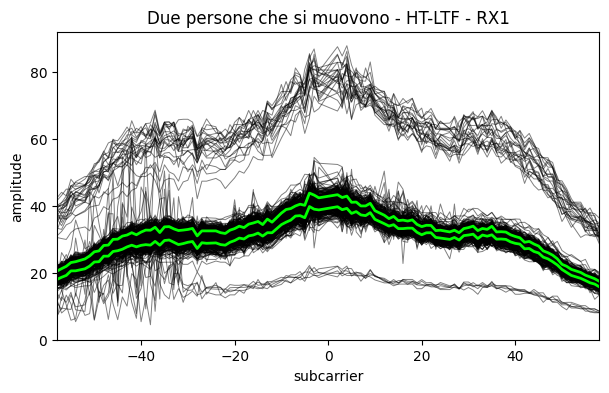

In [33]:
ax= plot_csi_bundle(bundles_due_movimento_htltf[2], subcarrier_idx=subcarriers_htltf, title='Due persone che si muovono - HT-LTF - RX1')

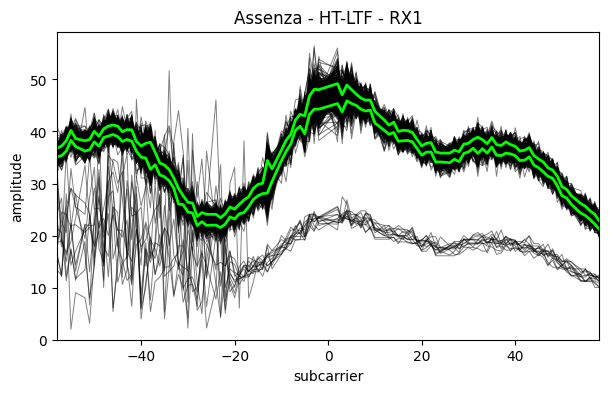

In [36]:
ax= plot_csi_bundle(bundles_assenza_htltf[1], subcarrier_idx=subcarriers_htltf, title='Assenza - HT-LTF - RX1')

In [38]:
def apply_hampel_to_bundle(bundle, window_size=5, n_sigma=3.0):
    # bundle shape: (n_packets, n_subcarriers)
    n_packets, n_subcarriers = bundle.shape
    filtered = np.zeros_like(bundle)
    for i in range(n_subcarriers):
        res = hampel(bundle[:, i], window_size=window_size, n_sigma=n_sigma)
        filtered[:, i] = res.filtered_data
    return filtered

In [39]:
bundles_hampel_assenza_htltf = [apply_hampel_to_bundle(b) for b in bundles_assenza_htltf]

bundles_hampel_due_movimento_htltf = [apply_hampel_to_bundle(b) for b in bundles_due_movimento_htltf]

bundles_hampel_due_ferme_htltf = [apply_hampel_to_bundle(b) for b in bundles_due_ferme_htltf]

bundles_hampel_una_movimento_htltf = [apply_hampel_to_bundle(b) for b in bundles_una_movimento_htltf]

bundles_hampel_una_ferma_htltf = [apply_hampel_to_bundle(b) for b in bundles_una_ferma_htltf]

bundles_hampel_una_entra_esce_htltf = [apply_hampel_to_bundle(b) for b in bundles_una_entra_esce_htltf]


#LLTF 

bundles_hampel_assenza_lltf = [apply_hampel_to_bundle(b) for b in bundles_assenza_lltf]

bundles_hampel_due_movimento_lltf = [apply_hampel_to_bundle(b) for b in bundles_due_movimento_lltf]

bundles_hampel_due_ferme_lltf = [apply_hampel_to_bundle(b) for b in bundles_due_ferme_lltf]

bundles_hampel_una_movimento_lltf = [apply_hampel_to_bundle(b) for b in bundles_una_movimento_lltf]

bundles_hampel_una_ferma_lltf = [apply_hampel_to_bundle(b) for b in bundles_una_ferma_lltf]

bundles_hampel_una_entra_esce_lltf = [apply_hampel_to_bundle(b) for b in bundles_una_entra_esce_lltf]


In [40]:
def plot_csi_bundles_comparison_3d(bundle_raw, bundle_filtered, 
                                   title_raw="Raw CSI Bundle", 
                                   title_filtered="Filtered CSI Bundle",
                                   elev=30, azim=-60, cmap='viridis'):
    """
    Plotta a confronto due bundle CSI (raw e filtrato) in 3D affiancati.
    Ogni bundle: array shape (n_packets, n_subcarriers)
    """
    fig = plt.figure(figsize=(16, 6))
    
    # Primo subplot: raw
    ax1 = fig.add_subplot(121, projection='3d')
    X1, Y1 = np.meshgrid(np.arange(bundle_raw.shape[1]), np.arange(bundle_raw.shape[0]))
    surf1 = ax1.plot_surface(X1, Y1, bundle_raw, cmap=cmap, linewidth=0, antialiased=True)
    ax1.set_title(title_raw)
    ax1.set_xlabel('Subcarrier')
    ax1.set_ylabel('Packet')
    ax1.set_zlabel('|CSI| Amplitude')
    ax1.view_init(elev=elev, azim=azim)
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    # Secondo subplot: filtered
    ax2 = fig.add_subplot(122, projection='3d')
    X2, Y2 = np.meshgrid(np.arange(bundle_filtered.shape[1]), np.arange(bundle_filtered.shape[0]))
    surf2 = ax2.plot_surface(X2, Y2, bundle_filtered, cmap=cmap, linewidth=0, antialiased=True)
    ax2.set_title(title_filtered)
    ax2.set_xlabel('Subcarrier')
    ax2.set_ylabel('Packet')
    ax2.set_zlabel('|CSI| Amplitude')
    ax2.view_init(elev=elev, azim=azim)
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    plt.tight_layout()
    plt.show()

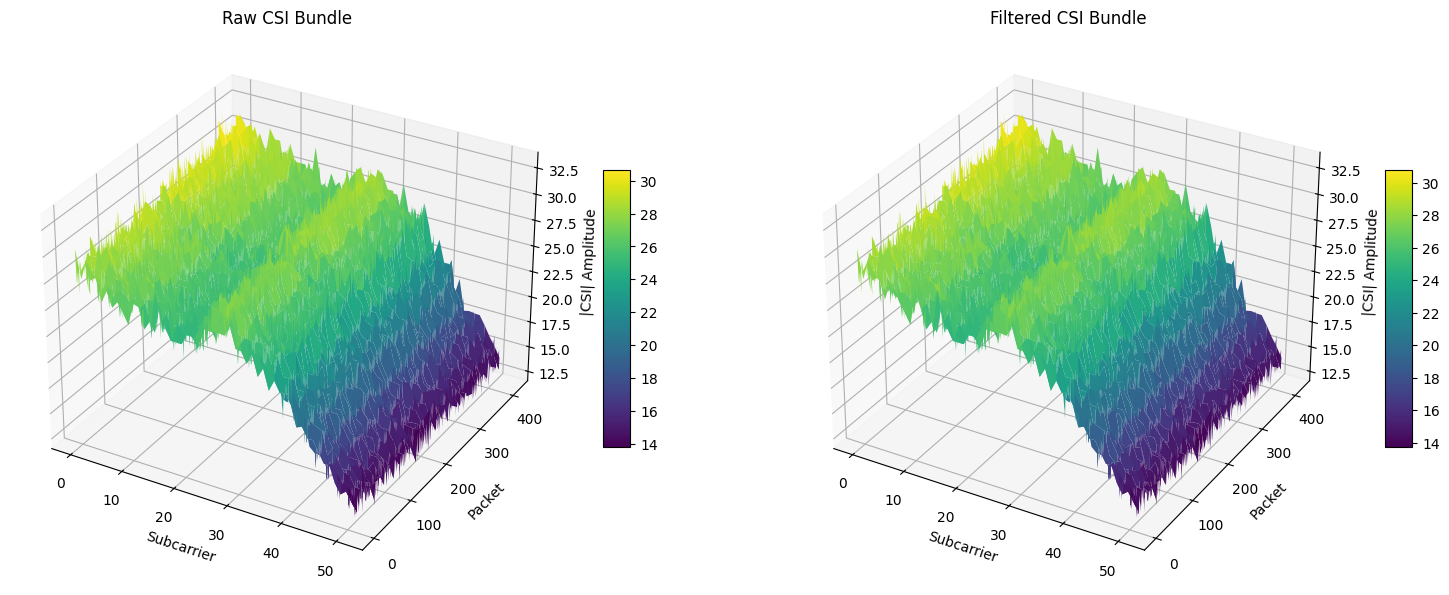

In [41]:
plot_csi_bundles_comparison_3d(bundles_due_ferme_lltf[10], bundles_hampel_due_ferme_lltf[10])

In [42]:
def apply_savgol_to_bundle(bundle, sg_window=11, sg_order=2):
    """
    Applica il filtro Savitzky-Golay a ciascun subcarrier di un bundle.
    bundle: array (n_packets, n_subcarriers)
    """
    bundle_savgol = np.zeros_like(bundle)
    n_packets = bundle.shape[0]
    for j in range(bundle.shape[1]):
        # Assicura che window_length sia dispari e non maggiore di n_packets
        win = min(sg_window, n_packets if n_packets % 2 == 1 else n_packets-1)
        if win < sg_order+2: win = sg_order+2 | 1  # almeno ordine+2, dispari
        bundle_savgol[:, j] = savgol_filter(bundle[:, j], window_length=win, polyorder=sg_order, mode='interp')
    return bundle_savgol


In [44]:
bundles_savgol_assenza_htltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_assenza_htltf]

bundles_savgol_due_movimento_htltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_due_movimento_htltf]

bundles_savgol_due_ferme_htltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_due_ferme_htltf]

bundles_savgol_una_movimento_htltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_una_movimento_htltf]

bundles_savgol_una_ferma_htltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_una_ferma_htltf]

bundles_savgol_una_entra_esce_htltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_una_entra_esce_htltf]



bundles_savgol_assenza_lltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_assenza_lltf]

bundles_savgol_due_movimento_lltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_due_movimento_lltf]

bundles_savgol_due_ferme_lltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_due_ferme_lltf]

bundles_savgol_una_movimento_lltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_una_movimento_lltf]

bundles_savgol_una_ferma_lltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_una_ferma_lltf]

bundles_savgol_una_entra_esce_lltf = [apply_savgol_to_bundle(b) for b in bundles_hampel_una_entra_esce_lltf]



In [45]:
def plot_all_csi_bundles_comparison_3d_triple(
        bundles_raw, bundles_hampel, bundles_savgol, 
        elev=30, azim=-60, cmap='viridis', 
        max_to_plot=5):
    """
    Visualizza affiancati tutti i bundle raw, hampel e hampel+savgol (fino a max_to_plot).
    Ogni bundle: array shape (n_packets, n_subcarriers)
    """
    n = min(len(bundles_raw), len(bundles_hampel), len(bundles_savgol), max_to_plot)
    fig = plt.figure(figsize=(18, 4 * n))
    for i in range(n):
        # RAW
        ax1 = fig.add_subplot(n, 3, 3*i+1, projection='3d')
        X1, Y1 = np.meshgrid(np.arange(bundles_raw[i].shape[1]), np.arange(bundles_raw[i].shape[0]))
        ax1.plot_surface(X1, Y1, bundles_raw[i], cmap=cmap, linewidth=0, antialiased=True)
        ax1.set_title(f'Raw Bundle {i}')
        ax1.set_xlabel('Subcarrier')
        ax1.set_ylabel('Packet')
        ax1.set_zlabel('|CSI|')
        ax1.view_init(elev=elev, azim=azim)

        # HAMPEL
        ax2 = fig.add_subplot(n, 3, 3*i+2, projection='3d')
        X2, Y2 = np.meshgrid(np.arange(bundles_hampel[i].shape[1]), np.arange(bundles_hampel[i].shape[0]))
        ax2.plot_surface(X2, Y2, bundles_hampel[i], cmap=cmap, linewidth=0, antialiased=True)
        ax2.set_title(f'Hampel Bundle {i}')
        ax2.set_xlabel('Subcarrier')
        ax2.set_ylabel('Packet')
        ax2.set_zlabel('|CSI|')
        ax2.view_init(elev=elev, azim=azim)

        # HAMPEL + SAVITZKY-GOLAY
        ax3 = fig.add_subplot(n, 3, 3*i+3, projection='3d')
        X3, Y3 = np.meshgrid(np.arange(bundles_savgol[i].shape[1]), np.arange(bundles_savgol[i].shape[0]))
        ax3.plot_surface(X3, Y3, bundles_savgol[i], cmap=cmap, linewidth=0, antialiased=True)
        ax3.set_title(f'Hampel + SavGol Bundle {i}')
        ax3.set_xlabel('Subcarrier')
        ax3.set_ylabel('Packet')
        ax3.set_zlabel('|CSI|')
        ax3.view_init(elev=elev, azim=azim)

    plt.tight_layout()
    plt.show()

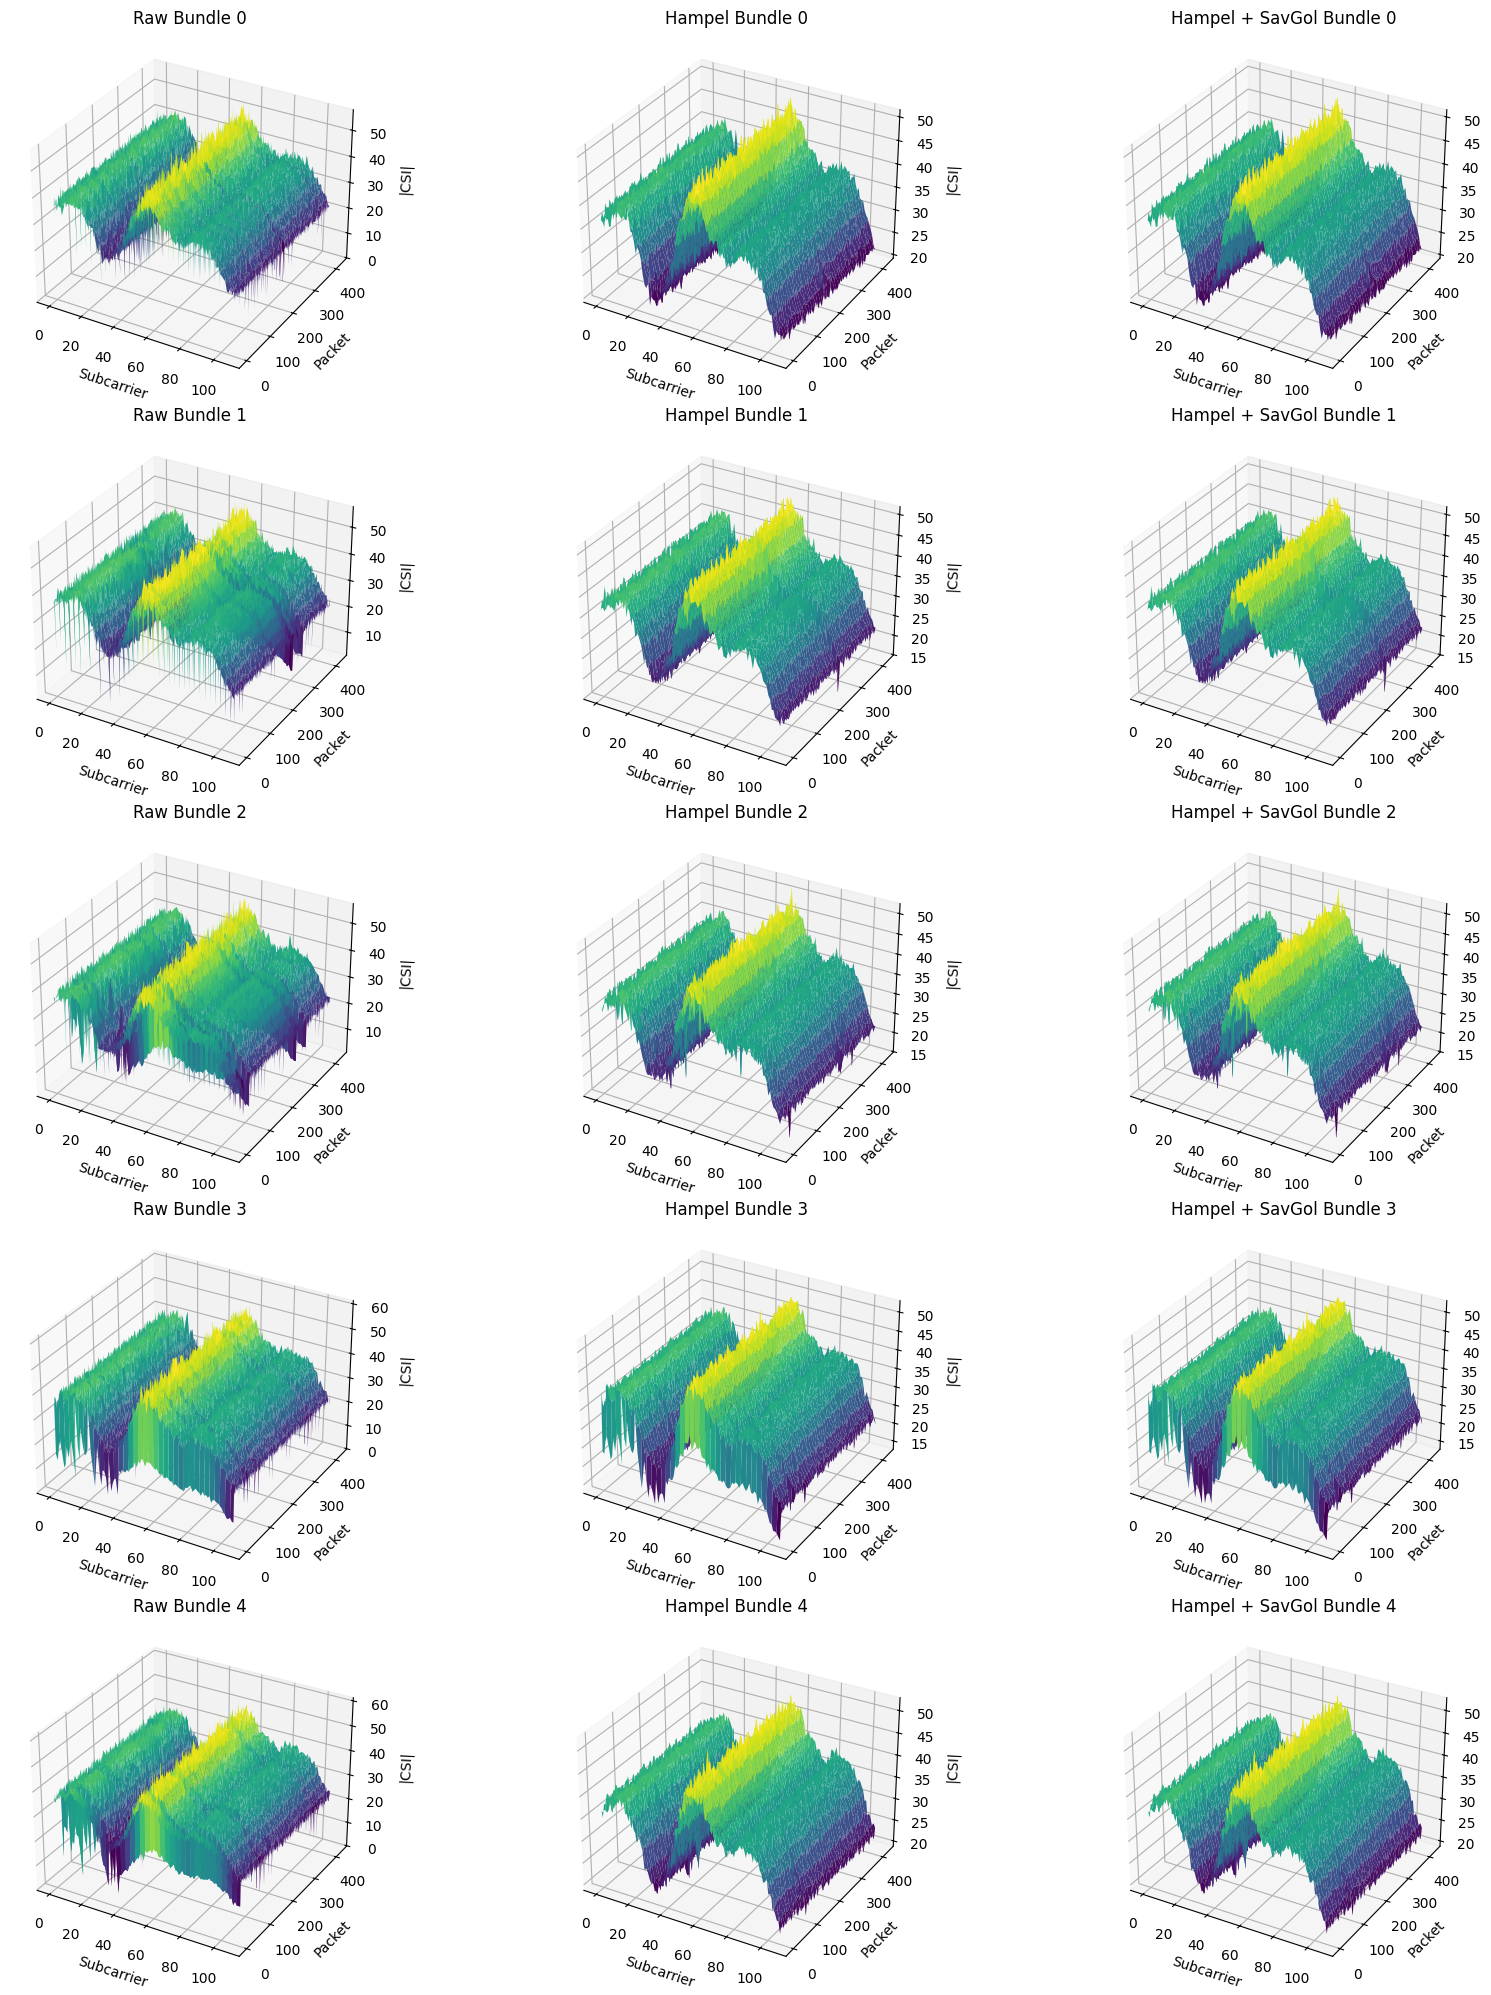

In [46]:
plot_all_csi_bundles_comparison_3d_triple(
    bundles_assenza_htltf,
    bundles_savgol_assenza_htltf,
    bundles_savgol_assenza_htltf
)

In [47]:
def plot_all_csi_bundles_comparison_2d(
        bundles_raw, bundles_hampel, bundles_savgol, 
        subcarrier=0, max_to_plot=5):
    """
    Visualizza in 2D (lineplot) le tracce temporali di un subcarrier per raw, hampel, hampel+savgol.
    Ogni plot: asse x = pacchetto, asse y = |CSI|
    """
    n = min(len(bundles_raw), len(bundles_hampel), len(bundles_savgol), max_to_plot)
    plt.figure(figsize=(10, 3 * n))
    for i in range(n):
        plt.subplot(n, 1, i+1)
        plt.plot(bundles_raw[i][:, subcarrier], label='Raw', color='C0', alpha=0.7)
        plt.plot(bundles_hampel[i][:, subcarrier], label='Hampel', color='C1', alpha=0.7)
        plt.plot(bundles_savgol[i][:, subcarrier], label='Hampel + SavGol', color='C2', alpha=0.7)
        plt.title(f'Bundle {i} - Subcarrier {subcarrier}')
        plt.xlabel('Packet Index')
        plt.ylabel('|CSI|')
        plt.legend()
        plt.tight_layout()
    plt.show()

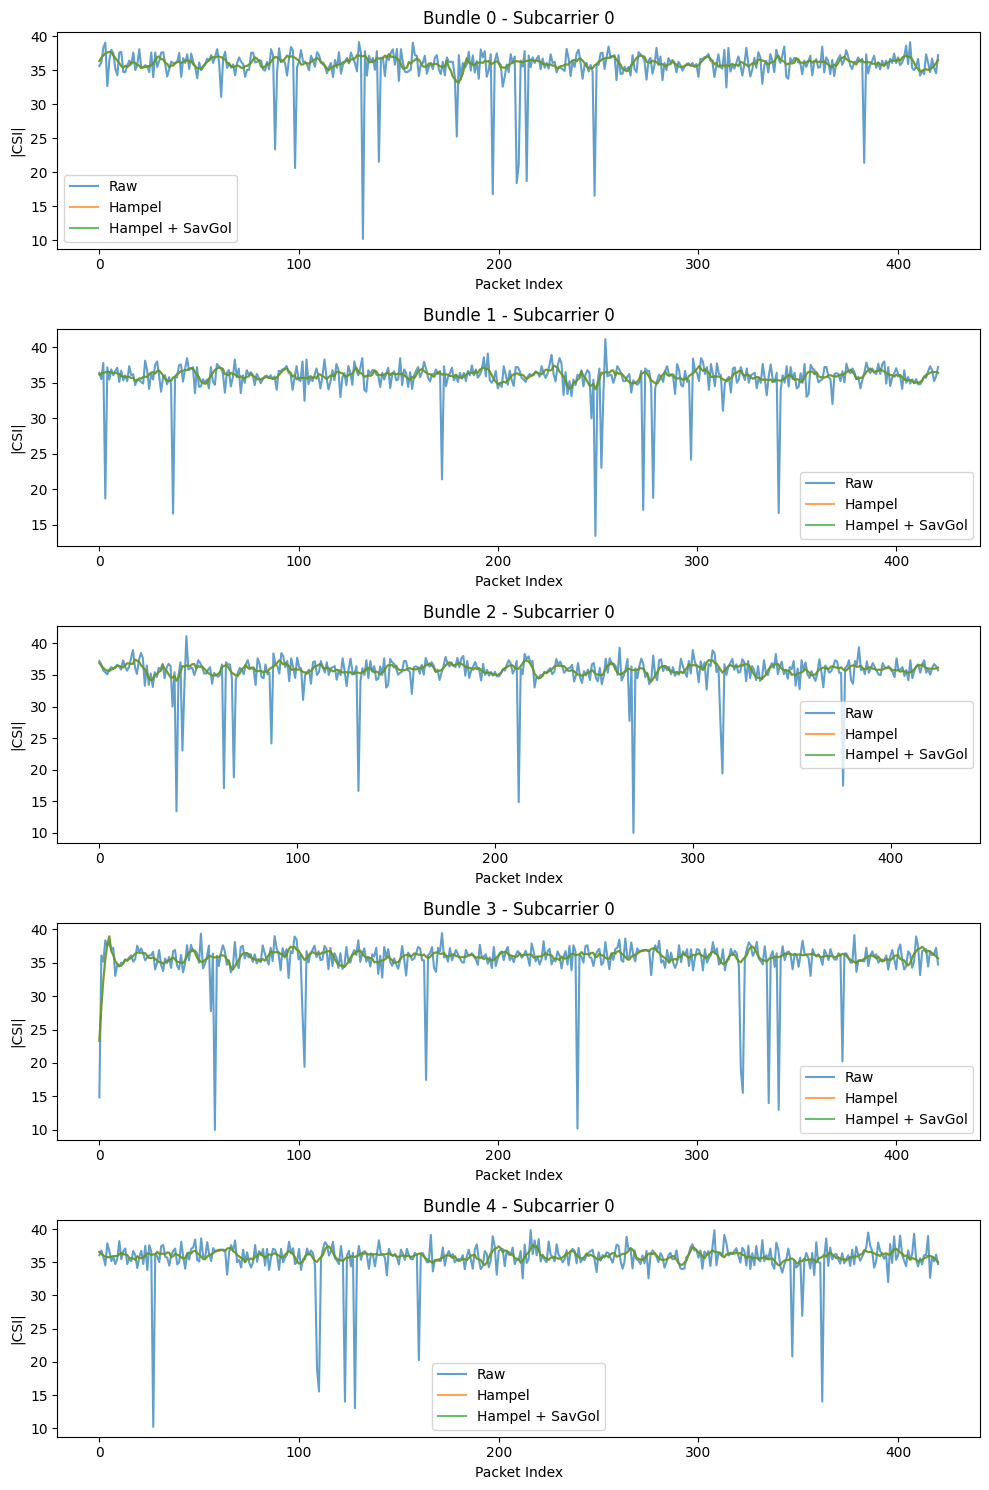

In [49]:
plot_all_csi_bundles_comparison_2d(   bundles_assenza_htltf,
    bundles_savgol_assenza_htltf,
    bundles_savgol_assenza_htltf, subcarrier=0, max_to_plot=5)

In [50]:
def extract_features_per_subcarrier(csi_matrix):
    """
    csi_matrix: array (N_win, N_subcarriers)
    Output: dict con feature vettoriali (shape (N_win, N_subcarriers))

    """
    feats = {}
    
    feats["std"] = np.std(csi_matrix, axis=0)   # per subcarrier, quindi nella prima finestra calcolo la deviazine su tutta la finestra e cosi via
    feats["min"] = np.min(csi_matrix, axis=0)
    feats["max"] = np.max(csi_matrix, axis=0)
    feats["avg"] = np.mean(csi_matrix, axis=0)
    feats["qtl"] = np.percentile(csi_matrix, 25, axis=0)
    feats["qtu"] = np.percentile(csi_matrix, 75, axis=0)
    feats["iqr"] = feats["qtu"] - feats["qtl"]
    
    return feats


In [51]:
def extract_adj_feature_all_windows(csi_windows, N=2):
    """
    Calcola la feature 'adj' per ciascuna finestra CSI (come nel paper Wi-CaL).
    
    Parametri
    ----------
    csi_windows : list of np.ndarray
        Ogni elemento è una matrice (N_pkt, N_subcarriers)
    N : int
        Numero di sottocarrier adiacenti da considerare su ciascun lato

    Ritorna
    -------
    adj_all : list of np.ndarray
        Lista di vettori (uno per finestra), ciascuno lungo (N_subcarriers - 2*N)
    """
    adj_all = []
    for w, csi_matrix in enumerate(csi_windows):
        n_pkt, n_subc = csi_matrix.shape
        adj_values = []

        for j in range(N, n_subc - N):  # evitiamo i bordi
            xi_j = np.zeros(n_pkt)
            for n in range(1, N + 1):
                xi_j += np.abs(csi_matrix[:, j] - csi_matrix[:, j - n])
                xi_j += np.abs(csi_matrix[:, j] - csi_matrix[:, j + n])
            mu_j = np.mean(xi_j)
            adj_values.append(mu_j)

        adj_all.append(np.array(adj_values))
    return adj_all


In [52]:
def extract_euc_feature_all_windows(csi_windows):
    """
    Calcola la feature 'euc' (Euclidean distance tra pacchetti consecutivi)
    per ciascuna finestra CSI, come da paper Wi-CaL.

    Parametri
    ----------
    csi_windows : list of np.ndarray
        Ogni elemento è una matrice (N_pkt, N_subcarriers)

    Ritorna
    -------
    euc_all : list of float
        Lista di valori 'euc', uno per finestra
    """
    euc_all = []

    for w, csi_matrix in enumerate(csi_windows):
        if csi_matrix.shape[0] < 2:
            euc_all.append(np.nan)  # finestra troppo corta, eviti errore
            continue

        # Differenze tra pacchetti consecutivi
        diffs = np.diff(csi_matrix, axis=0)            # shape (N_pkt-1, N_subcarriers)
        norms = np.linalg.norm(diffs, axis=1)          # distanza euclidea per ogni coppia
        euc_val = np.median(norms)                     # mediana come nel paper

        euc_all.append(euc_val)

    return np.array(euc_all)


In [79]:
#caloclo la feature adj per ogni condizione e per ogni ricevitore LLTF
adj_assenza_lltf = extract_adj_feature_all_windows(bundles_savgol_assenza_lltf, N=2)
df_adj_assenza_lltf = pd.DataFrame(adj_assenza_lltf)
assenza_adj_lltf = df_adj_assenza_lltf.values.tolist()


adj_due_movimento_lltf = extract_adj_feature_all_windows(bundles_savgol_due_movimento_lltf, N=2)
df_adj_due_movimento_lltf = pd.DataFrame(adj_due_movimento_lltf)
due_movimento_adj_lltf = df_adj_due_movimento_lltf.values.tolist()


adj_due_ferme_lltf = extract_adj_feature_all_windows(bundles_savgol_due_ferme_lltf, N=2)
df_adj_due_ferme_lltf = pd.DataFrame(adj_due_ferme_lltf)
due_ferme_adj_lltf = df_adj_due_ferme_lltf.values.tolist()


adj_una_movimento_lltf = extract_adj_feature_all_windows(bundles_savgol_una_movimento_lltf, N=2)
df_adj_una_movimento_lltf = pd.DataFrame(adj_una_movimento_lltf)
una_movimento_adj_lltf = df_adj_una_movimento_lltf.values.tolist()


adj_una_ferma_lltf = extract_adj_feature_all_windows(bundles_savgol_una_ferma_lltf, N=2)
df_adj_una_ferma_lltf = pd.DataFrame(adj_una_ferma_lltf)
una_ferma_adj_lltf = df_adj_una_ferma_lltf.values.tolist()

adj_una_entra_esce_lltf = extract_adj_feature_all_windows(bundles_savgol_una_entra_esce_lltf, N=2)
df_adj_una_entra_esce_lltf = pd.DataFrame(adj_una_entra_esce_lltf)
una_entra_esce_adj_lltf = df_adj_una_entra_esce_lltf.values.tolist()




In [80]:
#caloclo la feature adj per ogni condizione e per ogni ricevitore htltf
adj_assenza_htltf = extract_adj_feature_all_windows(bundles_savgol_assenza_htltf, N=2)
df_adj_assenza_htltf = pd.DataFrame(adj_assenza_htltf)
assenza_adj_htltf = df_adj_assenza_htltf.values.tolist()


adj_due_movimento_htltf = extract_adj_feature_all_windows(bundles_savgol_due_movimento_htltf, N=2)
df_adj_due_movimento_htltf = pd.DataFrame(adj_due_movimento_htltf)
due_movimento_adj_htltf = df_adj_due_movimento_htltf.values.tolist()


adj_due_ferme_htltf = extract_adj_feature_all_windows(bundles_savgol_due_ferme_htltf, N=2)
df_adj_due_ferme_htltf = pd.DataFrame(adj_due_ferme_htltf)
due_ferme_adj_htltf = df_adj_due_ferme_htltf.values.tolist()


adj_una_movimento_htltf = extract_adj_feature_all_windows(bundles_savgol_una_movimento_htltf, N=2)
df_adj_una_movimento_htltf = pd.DataFrame(adj_una_movimento_htltf)
una_movimento_adj_htltf = df_adj_una_movimento_htltf.values.tolist()


adj_una_ferma_htltf = extract_adj_feature_all_windows(bundles_savgol_una_ferma_htltf, N=2)
df_adj_una_ferma_htltf = pd.DataFrame(adj_una_ferma_htltf)
una_ferma_adj_htltf = df_adj_una_ferma_htltf.values.tolist()

adj_una_entra_esce_htltf = extract_adj_feature_all_windows(bundles_savgol_una_entra_esce_htltf, N=2)
df_adj_una_entra_esce_htltf = pd.DataFrame(adj_una_entra_esce_htltf)
una_entra_esce_adj_htltf = df_adj_una_entra_esce_htltf.values.tolist()


In [81]:
#caloclo la feature euc per ogni condizione e per ogni ricevitore LLTF
euc_assenza_lltf = extract_euc_feature_all_windows(bundles_savgol_assenza_lltf)
df_euc_assenza_lltf = pd.DataFrame(euc_assenza_lltf)


euc_due_movimento_lltf = extract_euc_feature_all_windows(bundles_savgol_due_movimento_lltf)
df_euc_due_movimento_lltf = pd.DataFrame(euc_due_movimento_lltf)


euc_due_ferme_lltf = extract_euc_feature_all_windows(bundles_savgol_due_ferme_lltf)
df_euc_due_ferme_lltf = pd.DataFrame(euc_due_ferme_lltf)


euc_una_movimento_lltf = extract_euc_feature_all_windows(bundles_savgol_una_movimento_lltf)
df_euc_una_movimento_lltf = pd.DataFrame(euc_una_movimento_lltf)


euc_una_ferma_lltf = extract_euc_feature_all_windows(bundles_savgol_una_ferma_lltf)
df_euc_una_ferma_lltf = pd.DataFrame(euc_una_ferma_lltf)

euc_una_entra_esce_lltf = extract_euc_feature_all_windows(bundles_savgol_una_entra_esce_lltf)
df_euc_una_entra_esce_lltf = pd.DataFrame(euc_una_entra_esce_lltf)

In [82]:
#caloclo la feature euc per ogni condizione e per ogni ricevitore htltf
euc_assenza_htltf = extract_euc_feature_all_windows(bundles_savgol_assenza_htltf)
df_euc_assenza_htltf = pd.DataFrame(euc_assenza_htltf)

euc_due_movimento_htltf = extract_euc_feature_all_windows(bundles_savgol_due_movimento_htltf)
df_euc_due_movimento_htltf = pd.DataFrame(euc_due_movimento_htltf)


euc_due_ferme_htltf = extract_euc_feature_all_windows(bundles_savgol_due_ferme_htltf)
df_euc_due_ferme_htltf = pd.DataFrame(euc_due_ferme_htltf)

euc_una_movimento_htltf = extract_euc_feature_all_windows(bundles_savgol_una_movimento_htltf)
df_euc_una_movimento_htltf = pd.DataFrame(euc_una_movimento_htltf)

euc_una_ferma_htltf = extract_euc_feature_all_windows(bundles_savgol_una_ferma_htltf)
df_euc_una_ferma_htltf = pd.DataFrame(euc_una_ferma_htltf)

euc_una_entra_esce_htltf = extract_euc_feature_all_windows(bundles_savgol_una_entra_esce_htltf)
df_euc_una_entra_esce_htltf = pd.DataFrame(euc_una_entra_esce_htltf)


In [83]:
# calcolo prima le feature come std, min, max, avg etc LLTF

features_assenza_lltf = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_assenza_lltf]
df_features_assenza_lltf = pd.DataFrame(features_assenza_lltf)
df_features_assenza_lltf["adj"] = assenza_adj_lltf


features_unapersonaferma = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_una_ferma_lltf]
df_features_una_ferma_lltf = pd.DataFrame(features_unapersonaferma)
df_features_una_ferma_lltf["adj"] = una_ferma_adj_lltf


features_unapersonachesimuove = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_una_movimento_lltf]
df_features_una_movimento_lltf = pd.DataFrame(features_unapersonachesimuove)
df_features_una_movimento_lltf["adj"] = una_movimento_adj_lltf


features_duepersoneferma = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_due_ferme_lltf]
df_features_due_ferme_lltf = pd.DataFrame(features_duepersoneferma)
df_features_due_ferme_lltf["adj"] = due_ferme_adj_lltf


features_duepersonechesimuovono = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_due_movimento_lltf]
df_features_due_movimento_lltf = pd.DataFrame(features_duepersonechesimuovono)
df_features_due_movimento_lltf["adj"] = due_movimento_adj_lltf

features_unapersonaentraesce = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_una_entra_esce_lltf]
df_features_una_entra_esce_lltf = pd.DataFrame(features_unapersonaentraesce)
df_features_una_entra_esce_lltf["adj"] = una_entra_esce_adj_lltf


In [84]:
# calcolo prima le feature come std, min, max, avg etc HTLTF

features_assenza_htltf = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_assenza_htltf]
df_features_assenza_htltf = pd.DataFrame(features_assenza_htltf)
df_features_assenza_htltf["adj"] = assenza_adj_htltf # adj viene calcolata in maniera diversa per questo in questa fase la aggiungo manualmente


features_unapersonaferma = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_una_ferma_htltf]
df_features_una_ferma_htltf = pd.DataFrame(features_unapersonaferma)
df_features_una_ferma_htltf["adj"] = una_ferma_adj_htltf


features_unapersonachesimuove = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_una_movimento_htltf]
df_features_una_movimento_htltf = pd.DataFrame(features_unapersonachesimuove)
df_features_una_movimento_htltf["adj"] = una_movimento_adj_htltf


features_duepersoneferma = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_due_ferme_htltf]
df_features_due_ferme_htltf = pd.DataFrame(features_duepersoneferma)
df_features_due_ferme_htltf["adj"] = due_ferme_adj_htltf


features_duepersonechesimuovono = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_due_movimento_htltf]
df_features_due_movimento_htltf = pd.DataFrame(features_duepersonechesimuovono)
df_features_due_movimento_htltf["adj"] = due_movimento_adj_htltf

features_unapersonaentraesce = [extract_features_per_subcarrier(mat) for mat in bundles_savgol_una_entra_esce_htltf]
df_features_una_entra_esce_htltf = pd.DataFrame(features_unapersonaentraesce)
df_features_una_entra_esce_htltf["adj"] = una_entra_esce_adj_htltf


In [65]:
std_values = np.array([f["std"] for f in features_assenza_htltf])
print("Forma:", std_values.shape)
print("lunghezza bundle:", len(bundles_assenza_htltf))
print("lunghezza singolo valore di std, sarebbe std^(w): ", len(std_values[1]))
print("Valori della colonna std", std_values) #compone la prima colonna della matrice, questo è link 1 quindi kw=1


Forma: (165, 108)
lunghezza bundle: 165
lunghezza singolo valore di std, sarebbe std^(w):  108
Valori della colonna std [[0.60529832 0.62793767 0.67517972 ... 0.49216451 0.64163917 0.57065259]
 [0.56015366 0.62248581 0.69352561 ... 0.58082463 0.60377254 0.89695187]
 [0.62036172 0.82221002 0.65877985 ... 0.80938932 0.74647761 0.99686632]
 ...
 [0.71910948 0.76521743 0.66107269 ... 0.58881173 0.56236944 0.63622095]
 [0.80429035 0.71634827 0.86542766 ... 0.68693802 0.72440335 0.68555174]
 [0.66639526 0.67509536 0.59754531 ... 0.54238682 0.54907007 0.58174605]]


In [97]:
matrice_min_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['min'].to_list())
matrice_max_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['max'].to_list())
matrice_std_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['std'].to_list())
matrice_avg_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['avg'].to_list())
matrice_qtl_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['qtl'].to_list())
matrice_qtu_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['qtu'].to_list())
matrice_iqr_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['iqr'].to_list())
matrice_adj_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['adj'].to_list())
matrice_euc_assenza_htltf = df_euc_assenza_htltf

matrice_min_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['min'].to_list())
matrice_max_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['max'].to_list())
matrice_std_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['std'].to_list())
matrice_avg_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['avg'].to_list())
matrice_qtl_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['qtl'].to_list())
matrice_qtu_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['qtu'].to_list())
matrice_iqr_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['iqr'].to_list())
matrice_adj_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['adj'].to_list())
matrice_euc_una_ferma_htltf = df_euc_una_ferma_htltf

matrice_min_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['min'].to_list())
matrice_max_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['max'].to_list())
matrice_std_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['std'].to_list())
matrice_avg_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['avg'].to_list())
matrice_qtl_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['qtl'].to_list())
matrice_qtu_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['qtu'].to_list())
matrice_iqr_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['iqr'].to_list())
matrice_adj_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['adj'].to_list())
matrice_euc_una_movimento_htltf = df_euc_una_movimento_htltf

matrice_min_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['min'].to_list())
matrice_max_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['max'].to_list())
matrice_std_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['std'].to_list())
matrice_avg_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['avg'].to_list())
matrice_qtl_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['qtl'].to_list())
matrice_qtu_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['qtu'].to_list())
matrice_iqr_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['iqr'].to_list())
matrice_adj_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['adj'].to_list())
matrice_euc_due_movimento_htltf = df_euc_due_movimento_htltf

matrice_min_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['min'].to_list())
matrice_max_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['max'].to_list())
matrice_std_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['std'].to_list())
matrice_avg_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['avg'].to_list())
matrice_qtl_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['qtl'].to_list())
matrice_qtu_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['qtu'].to_list())
matrice_iqr_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['iqr'].to_list())
matrice_adj_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['adj'].to_list())
matrice_euc_due_ferme_htltf = df_euc_due_ferme_htltf

matrice_min_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['min'].to_list())
matrice_max_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['max'].to_list())
matrice_std_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['std'].to_list())
matrice_avg_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['avg'].to_list())
matrice_qtl_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['qtl'].to_list())
matrice_qtu_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['qtu'].to_list())
matrice_iqr_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['iqr'].to_list())
matrice_adj_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['adj'].to_list())
matrice_euc_una_entra_esce_htltf = df_euc_una_entra_esce_htltf

In [94]:
matrice_min_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['min'].to_list())
matrice_max_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['max'].to_list())
matrice_std_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['std'].to_list())
matrice_avg_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['avg'].to_list())
matrice_qtl_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['qtl'].to_list())
matrice_qtu_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['qtu'].to_list())
matrice_iqr_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['iqr'].to_list())
matrice_adj_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['adj'].to_list())
matrice_euc_assenza_lltf = df_euc_assenza_lltf

matrice_min_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['min'].to_list())
matrice_max_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['max'].to_list())
matrice_std_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['std'].to_list())
matrice_avg_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['avg'].to_list())
matrice_qtl_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['qtl'].to_list())
matrice_qtu_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['qtu'].to_list())
matrice_iqr_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['iqr'].to_list())
matrice_adj_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['adj'].to_list())
matrice_euc_una_ferma_lltf = df_euc_una_ferma_lltf

matrice_min_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['min'].to_list())
matrice_max_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['max'].to_list())
matrice_std_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['std'].to_list())
matrice_avg_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['avg'].to_list())
matrice_qtl_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['qtl'].to_list())
matrice_qtu_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['qtu'].to_list())
matrice_iqr_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['iqr'].to_list())
matrice_adj_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['adj'].to_list())
matrice_euc_una_movimento_lltf = df_euc_una_movimento_lltf

matrice_min_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['min'].to_list())
matrice_max_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['max'].to_list())
matrice_std_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['std'].to_list())
matrice_avg_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['avg'].to_list())
matrice_qtl_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['qtl'].to_list())
matrice_qtu_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['qtu'].to_list())
matrice_iqr_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['iqr'].to_list())
matrice_adj_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['adj'].to_list())
matrice_euc_due_movimento_lltf = df_euc_due_movimento_lltf

matrice_min_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['min'].to_list())
matrice_max_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['max'].to_list())
matrice_std_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['std'].to_list())
matrice_avg_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['avg'].to_list())
matrice_qtl_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['qtl'].to_list())
matrice_qtu_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['qtu'].to_list())
matrice_iqr_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['iqr'].to_list())
matrice_adj_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['adj'].to_list())
matrice_euc_due_ferme_lltf = df_euc_due_ferme_lltf

matrice_min_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['min'].to_list())
matrice_max_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['max'].to_list())
matrice_std_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['std'].to_list())
matrice_avg_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['avg'].to_list())
matrice_qtl_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['qtl'].to_list())
matrice_qtu_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['qtu'].to_list())
matrice_iqr_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['iqr'].to_list())
matrice_adj_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['adj'].to_list())
matrice_euc_una_entra_esce_lltf = df_euc_una_entra_esce_lltf

* inizio con creazione dataset 

In [107]:
matrice_assenza_lltf = pd.concat([
    matrice_min_assenza_lltf,
    matrice_max_assenza_lltf,
    matrice_std_assenza_lltf,
    matrice_avg_assenza_lltf,
    matrice_qtl_assenza_lltf,
    matrice_qtu_assenza_lltf,
    matrice_iqr_assenza_lltf,
    matrice_adj_assenza_lltf,
    matrice_euc_assenza_lltf
], axis=1)

matrice_assenza_lltf["target"] = 0

matrice_una_ferma_lltf = pd.concat([
    matrice_min_una_ferma_lltf,
    matrice_max_una_ferma_lltf,
    matrice_std_una_ferma_lltf,
    matrice_avg_una_ferma_lltf,
    matrice_qtl_una_ferma_lltf,
    matrice_qtu_una_ferma_lltf,
    matrice_iqr_una_ferma_lltf,
    matrice_adj_una_ferma_lltf,
    matrice_euc_una_ferma_lltf
], axis=1)

matrice_una_ferma_lltf["target"] = 1

matrice_una_movimento_lltf = pd.concat([
    matrice_min_una_movimento_lltf,
    matrice_max_una_movimento_lltf,
    matrice_std_una_movimento_lltf,
    matrice_avg_una_movimento_lltf,
    matrice_qtl_una_movimento_lltf,
    matrice_qtu_una_movimento_lltf,
    matrice_iqr_una_movimento_lltf,
    matrice_adj_una_movimento_lltf,
    matrice_euc_una_movimento_lltf
], axis=1)

matrice_una_movimento_lltf["target"] = 2

matrice_due_ferme_lltf = pd.concat([
    matrice_min_due_ferme_lltf,
    matrice_max_due_ferme_lltf,
    matrice_std_due_ferme_lltf,
    matrice_avg_due_ferme_lltf,
    matrice_qtl_due_ferme_lltf,
    matrice_qtu_due_ferme_lltf,
    matrice_iqr_due_ferme_lltf,
    matrice_adj_due_ferme_lltf,
    matrice_euc_due_ferme_lltf
], axis=1)

matrice_due_ferme_lltf["target"] = 3

matrice_due_movimento_lltf = pd.concat([
    matrice_min_due_movimento_lltf,
    matrice_max_due_movimento_lltf,
    matrice_std_due_movimento_lltf,
    matrice_avg_due_movimento_lltf,
    matrice_qtl_due_movimento_lltf,
    matrice_qtu_due_movimento_lltf,
    matrice_iqr_due_movimento_lltf,
    matrice_adj_due_movimento_lltf,
    matrice_euc_due_movimento_lltf
], axis=1)

matrice_due_movimento_lltf["target"] = 4

In [108]:
matrice_assenza_htltf = pd.concat([
    matrice_min_assenza_htltf,
    matrice_max_assenza_htltf,
    matrice_std_assenza_htltf,
    matrice_avg_assenza_htltf,
    matrice_qtl_assenza_htltf,
    matrice_qtu_assenza_htltf,
    matrice_iqr_assenza_htltf,
    matrice_adj_assenza_htltf,
    matrice_euc_assenza_htltf
], axis=1)

matrice_assenza_htltf["target"] = 0

matrice_una_ferma_htltf = pd.concat([
    matrice_min_una_ferma_htltf,
    matrice_max_una_ferma_htltf,
    matrice_std_una_ferma_htltf,
    matrice_avg_una_ferma_htltf,
    matrice_qtl_una_ferma_htltf,
    matrice_qtu_una_ferma_htltf,
    matrice_iqr_una_ferma_htltf,
    matrice_adj_una_ferma_htltf,
    matrice_euc_una_ferma_htltf
], axis=1)

matrice_una_ferma_htltf["target"] = 1

matrice_una_movimento_htltf = pd.concat([
    matrice_min_una_movimento_htltf,
    matrice_max_una_movimento_htltf,
    matrice_std_una_movimento_htltf,
    matrice_avg_una_movimento_htltf,
    matrice_qtl_una_movimento_htltf,
    matrice_qtu_una_movimento_htltf,
    matrice_iqr_una_movimento_htltf,
    matrice_adj_una_movimento_htltf,
    matrice_euc_una_movimento_htltf
], axis=1)

matrice_una_movimento_htltf["target"] = 2

matrice_due_ferme_htltf = pd.concat([
    matrice_min_due_ferme_htltf,
    matrice_max_due_ferme_htltf,
    matrice_std_due_ferme_htltf,
    matrice_avg_due_ferme_htltf,
    matrice_qtl_due_ferme_htltf,
    matrice_qtu_due_ferme_htltf,
    matrice_iqr_due_ferme_htltf,
    matrice_adj_due_ferme_htltf,
    matrice_euc_due_ferme_htltf
], axis=1)

matrice_due_ferme_htltf["target"] = 3

matrice_due_movimento_htltf = pd.concat([
    matrice_min_due_movimento_htltf,
    matrice_max_due_movimento_htltf,
    matrice_std_due_movimento_htltf,
    matrice_avg_due_movimento_htltf,
    matrice_qtl_due_movimento_htltf,
    matrice_qtu_due_movimento_htltf,
    matrice_iqr_due_movimento_htltf,
    matrice_adj_due_movimento_htltf,
    matrice_euc_due_movimento_htltf
], axis=1)

matrice_due_movimento_htltf["target"] = 4

In [109]:
dataset_finale_lltf = pd.concat([
    matrice_assenza_lltf,
    matrice_una_ferma_lltf,
    matrice_una_movimento_lltf,
    matrice_due_ferme_lltf,
    matrice_due_movimento_lltf
], axis=0).reset_index(drop=True)

dataset_finale_htltf = pd.concat([
    matrice_assenza_htltf,
    matrice_una_ferma_htltf,
    matrice_una_movimento_htltf,
    matrice_due_ferme_htltf,
    matrice_due_movimento_htltf
], axis=0).reset_index(drop=True)



In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)


# k-Fold Cross-Validation

In [111]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline

In [112]:
# ===============================================================
# Funzione: esegue k-Fold CV 
# ===============================================================
def kfold_cross_validation(dataset, target_col="target", n_splits=5):
    """
    Esegue k-Fold Cross Validation per LR, RFR, XGBR e LGBMR.
    Restituisce media e std del MAE per ogni modello.
    """
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    # Definizione modelli
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1),
        "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
    }

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", model)
        ])
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, y, cv=kf, scoring=mae_scorer, n_jobs=-1)
        mae_mean = -scores.mean()
        mae_std = scores.std()
        results[name] = (mae_mean, mae_std)
        print(f"{name:20s} → MAE medio = {mae_mean:.4f} ± {mae_std:.4f}")

    results_df = pd.DataFrame(results, index=["MAE_mean", "MAE_std"]).T
    return results_df

In [113]:
print("===== K-FOLD CROSS-VALIDATION: LLTF =====")
cv_results_lltf = kfold_cross_validation(expanded_features_lltf, target_col="target", n_splits=5)

print("\n===== K-FOLD CROSS-VALIDATION: HT-LTF =====")
cv_results_htltf = kfold_cross_validation(expanded_features_htltf, target_col="target", n_splits=5)


===== K-FOLD CROSS-VALIDATION: LLTF =====


NameError: name 'expanded_features_lltf' is not defined

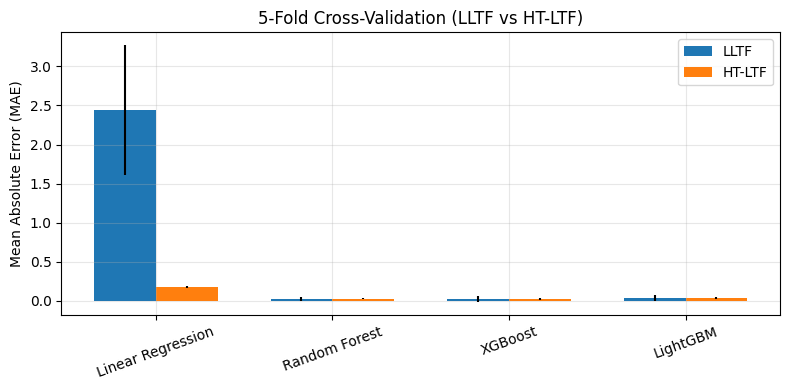

In [ ]:
plt.figure(figsize=(8,4))
x = np.arange(len(cv_results_lltf.index))
width = 0.35

plt.bar(x - width/2, cv_results_lltf["MAE_mean"], width, yerr=cv_results_lltf["MAE_std"], label="LLTF")
plt.bar(x + width/2, cv_results_htltf["MAE_mean"], width, yerr=cv_results_htltf["MAE_std"], label="HT-LTF")

plt.xticks(x, cv_results_lltf.index, rotation=20)
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("5-Fold Cross-Validation (LLTF vs HT-LTF)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# =======================================================
# Funzione per k-Fold CV dei modelli di classificazione
# =======================================================
def kfold_classification_cv(dataset, target_col="target", n_splits=5):
    """
    Esegue k-Fold Cross Validation per i modelli di classificazione.
    Ritorna accuracy media e deviazione standard per ogni modello.
    """
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    models = {
        "SVM (RBF)": SVC(kernel="rbf", C=10, gamma="scale"),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric="mlogloss"),
        "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "GBDT": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
    }

    accuracy_scorer = make_scorer(accuracy_score)
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", model)
        ])
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, y, cv=kf, scoring=accuracy_scorer, n_jobs=-1)
        acc_mean = scores.mean()
        acc_std = scores.std()
        results[name] = (acc_mean, acc_std)
        print(f"{name:20s} → Accuracy media = {acc_mean:.4f} ± {acc_std:.4f}")

    results_df = pd.DataFrame(results, index=["Accuracy_mean", "Accuracy_std"]).T
    return results_df

In [ ]:
print("===== K-FOLD CLASSIFICATION: LLTF =====")
cv_class_lltf = kfold_classification_cv(expanded_features_lltf, target_col="target")

print("\n===== K-FOLD CLASSIFICATION: HT-LTF =====")
cv_class_htltf = kfold_classification_cv(expanded_features_htltf, target_col="target")


===== K-FOLD CLASSIFICATION: LLTF =====
SVM (RBF)            → Accuracy media = 0.9978 ± 0.0027
KNN                  → Accuracy media = 0.9967 ± 0.0044
Random Forest        → Accuracy media = 0.9978 ± 0.0044
XGBoost              → Accuracy media = 0.9945 ± 0.0049
LightGBM             → Accuracy media = 0.9978 ± 0.0027
GBDT                 → Accuracy media = 0.9956 ± 0.0064

===== K-FOLD CLASSIFICATION: HT-LTF =====
SVM (RBF)            → Accuracy media = 1.0000 ± 0.0000
KNN                  → Accuracy media = 0.9989 ± 0.0022
Random Forest        → Accuracy media = 1.0000 ± 0.0000
XGBoost              → Accuracy media = 0.9978 ± 0.0027
LightGBM             → Accuracy media = 0.9956 ± 0.0041
GBDT                 → Accuracy media = 0.9956 ± 0.0041


# Nuove metriche per la regressione

In [114]:
def train_classifiers_2(dataset, target_col="target", titolo_suffix="Confusion Matrices"):

    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = {
        "SVM (RBF)": SVC(kernel="rbf", C=10, gamma="scale"),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42,
                                 use_label_encoder=False, eval_metric='mlogloss'),
        "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "GBDT": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
    }

    # Risultati
    f1_results = {}
    accuracy_results = {}
    time_results = {}
    metrics_table = []

    # -------------------------------
    # FIGURA UNICA DELLE CONFUSION MATRIX
    # -------------------------------
    n_models = len(models)
    n_cols = 3
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):

        # --- TEMPO DI TRAINING ---
        start = time.perf_counter()
        model.fit(X_train, y_train)
        train_time = time.perf_counter() - start
        time_results[name] = train_time

        # Predizione
        y_pred = model.predict(X_test)

        # Accuracy
        accuracy_results[name] = accuracy_score(y_test, y_pred)

        # Report
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_results[name] = f1_macro

        # METRICHE DETTAGLIATE
        for label, values in report_dict.items():
            if label.isdigit():
                metrics_table.append({
                    "Model": name,
                    "Class": label,
                    "Precision": values["precision"],
                    "Recall": values["recall"],
                    "F1-score": values["f1-score"],
                    "Support": values["support"],
                    "Train_time_sec": train_time
                })

        # Confusion matrix
        ax = axes[idx]
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f",
                    cmap="Blues", ax=ax)
        ax.set_title(f"{name}\nTraining time: {train_time:.3f} sec  | F1-macro: {f1_macro:.3f} | Accuracy: {accuracy_results[name]:.3f}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    # Rimuove subplot vuoti
    for i in range(idx+1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig(f"{titolo_suffix}.png", dpi=300)
    plt.show()
    print(f"\n📁 Confusion matrices salvate in:{titolo_suffix}.png")

    # -------------------------------
    # TABELLA RIASSUNTIVA ORDINATA PER F1 MACRO
    # -------------------------------
    f1_df = pd.DataFrame(
        {"Model": list(f1_results.keys()), 
         "F1_macro": list(f1_results.values()),
         "Train_time_sec": list(time_results.values())}
    ).sort_values("F1_macro", ascending=False)

    print("\n📊 Summary of F1 Macro scores (+ training time):")
    print(f1_df)



    # -------------------------------
    # TABELLA COMPLETA DELLE METRICHE
    # -------------------------------
    metrics_df = pd.DataFrame(metrics_table)

    print("\n📋 Full Classification Metrics Table (with training times):")
    print(metrics_df)

    return f1_df, metrics_df


In [115]:
import math
import time
import re

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:39:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192414
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 861
[LightGBM] [Info] Start training from score -1.762346
[LightGBM] [Info] Start training from score -1.616929
[LightGBM] [Info] Start training from score -1.632080
[LightGBM] [Info] Start training from score -1.503331
[LightGBM] [Info] Start training from score -1.551451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


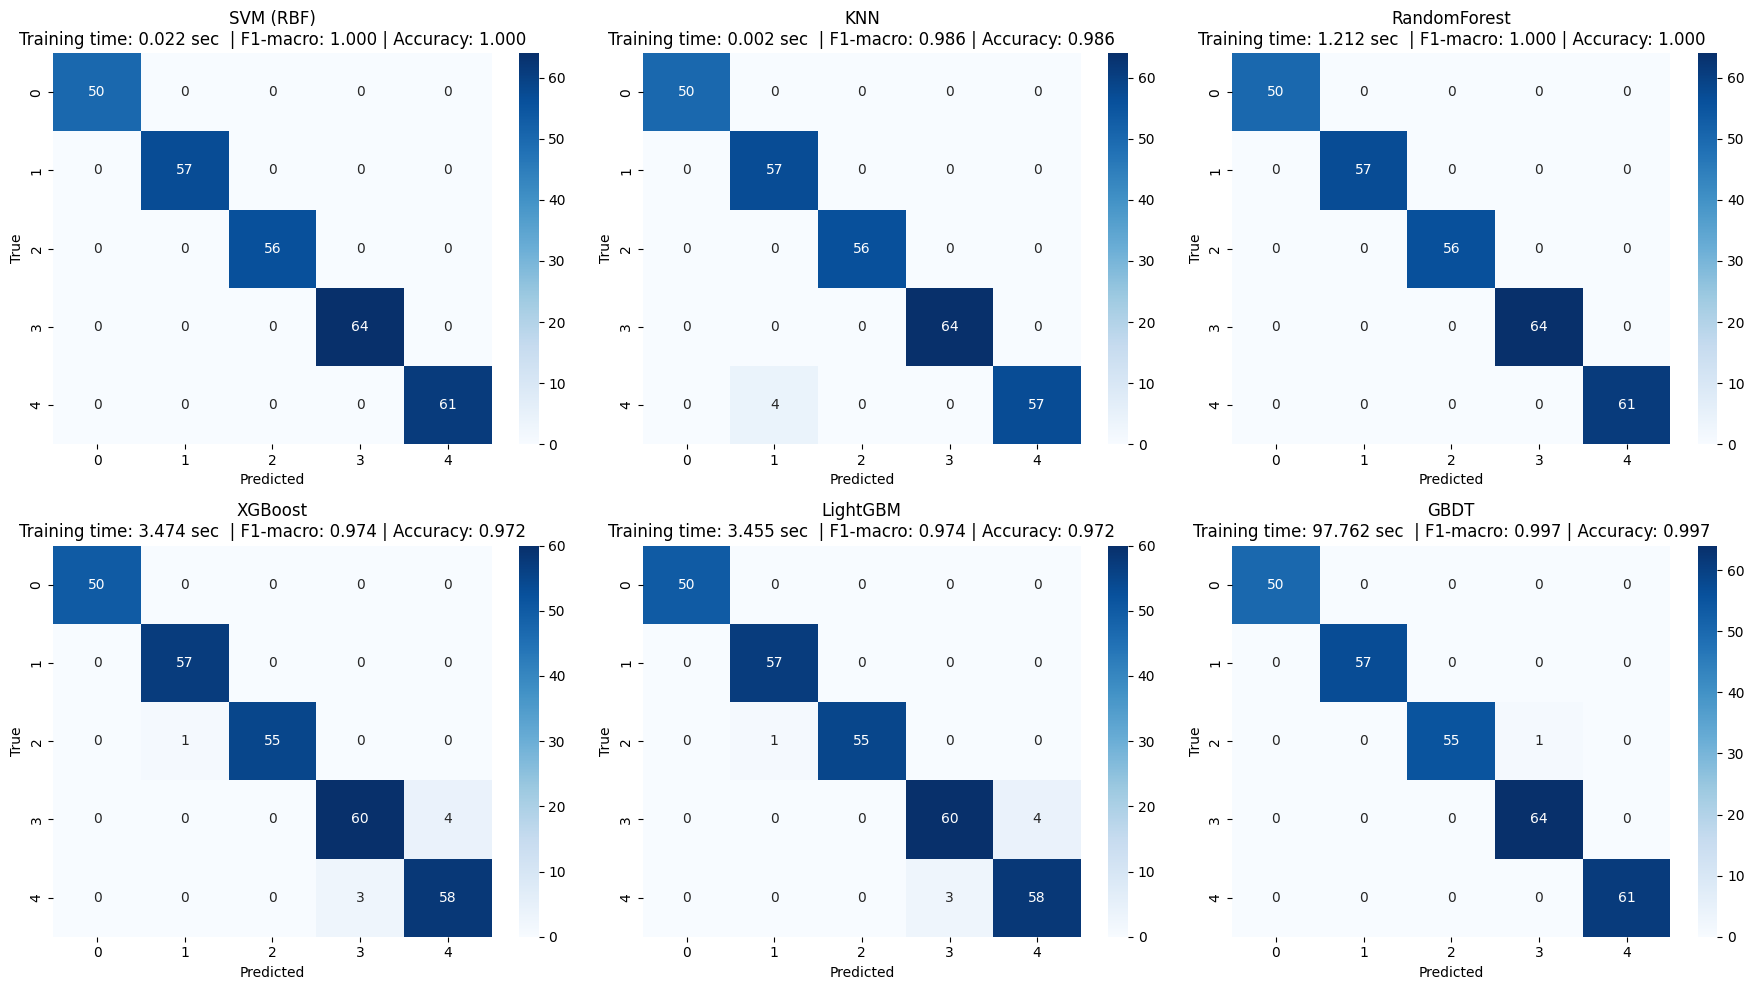


📁 Confusion matrices salvate in:Confusion Matrices HTLTF vecchi dati classi separate .png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.022380
2  RandomForest  1.000000        1.212022
5          GBDT  0.996648       97.762126
1           KNN  0.986441        0.002025
3       XGBoost  0.974053        3.473921
4      LightGBM  0.974053        3.455430

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     50.0        0.022380
1      SVM (RBF)     1   1.000000  1.000000  1.000000     57.0        0.022380
2      SVM (RBF)     2   1.000000  1.000000  1.000000     56.0        0.022380
3      SVM (RBF)     3   1.000000  1.000000  1.000000     64.0        0.022380
4      SVM (RBF)     4   1.000000  1.000000  1.000000     61.0        0.022380
5            KNN     0   1.00000

In [116]:
results_htltf = train_classifiers_2(dataset_finale_htltf,titolo_suffix="Confusion Matrices HTLTF vecchi dati classi separate ")


c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:41:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92284
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 413
[LightGBM] [Info] Start training from score -1.762346
[LightGBM] [Info] Start training from score -1.616929
[LightGBM] [Info] Start training from score -1.632080
[LightGBM] [Info] Start training from score -1.503331
[LightGBM] [Info] Start training from score -1.551451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


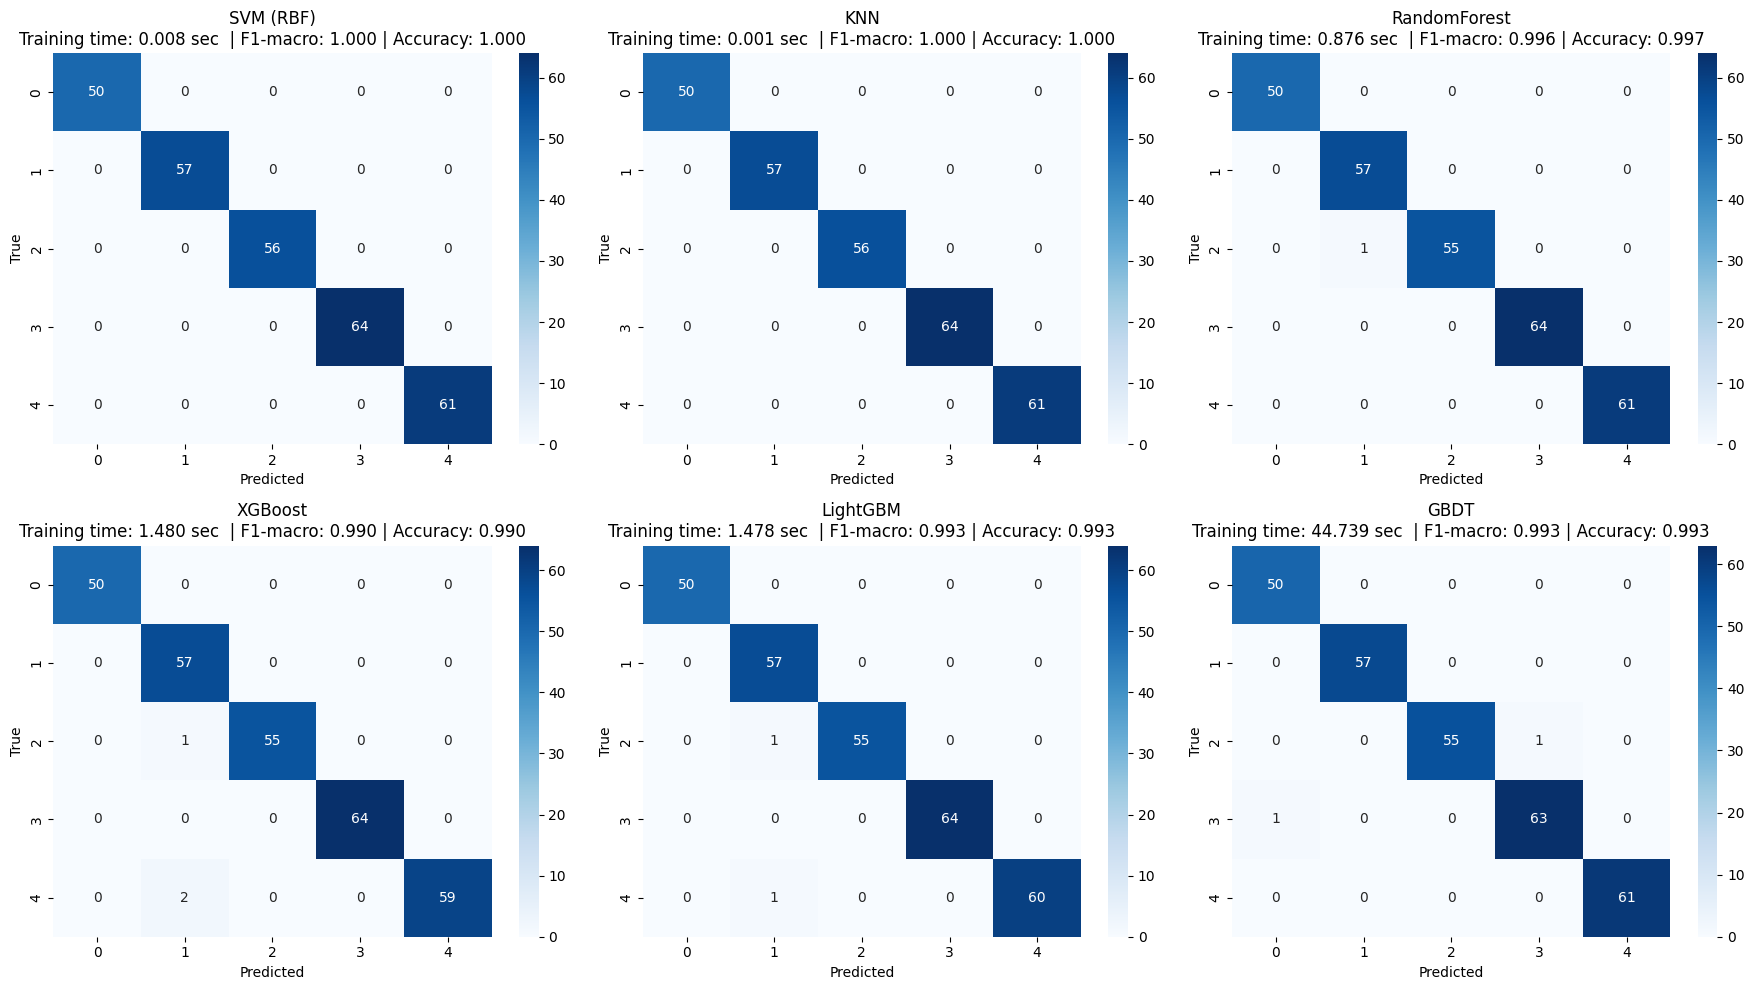


📁 Confusion matrices salvate in:Confusion Matrices LLTF vecchi dati classi separate .png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  1.000000        0.007646
1           KNN  1.000000        0.001113
2  RandomForest  0.996459        0.876284
4      LightGBM  0.993097        1.478440
5          GBDT  0.993093       44.738723
3       XGBoost  0.989737        1.480221

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     50.0        0.007646
1      SVM (RBF)     1   1.000000  1.000000  1.000000     57.0        0.007646
2      SVM (RBF)     2   1.000000  1.000000  1.000000     56.0        0.007646
3      SVM (RBF)     3   1.000000  1.000000  1.000000     64.0        0.007646
4      SVM (RBF)     4   1.000000  1.000000  1.000000     61.0        0.007646
5            KNN     0   1.000000

In [117]:
results_lltf = train_classifiers_2(dataset_finale_lltf,titolo_suffix="Confusion Matrices LLTF vecchi dati classi separate ")
